In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [29]:
df = pd.read_csv('datos_exportados_clean.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [30]:
df

,Fecha,Latitud,Longitud,SST
0,1981-09-01,19.875,-117.125,NaN
1,1981-09-01,20.125,-117.125,NaN
2,1981-09-01,20.375,-117.125,NaN
3,1981-09-01,20.625,-117.125,NaN
4,1981-09-01,20.875,-117.125,NaN
...,...,...,...,...
1319271,2023-12-01,30.875,-104.125,NaN
1319272,2023-12-01,31.125,-104.125,NaN
1319273,2023-12-01,31.375,-104.125,NaN
1319274,2023-12-01,31.625,-104.125,NaN


In [31]:
df.count()

Fecha       1319276
Latitud     1319276
Longitud    1319276
SST          186436
dtype: int64

In [32]:
df.dropna(inplace=True)

In [33]:
df.count()

Fecha       186436
Latitud     186436
Longitud    186436
SST         186436
dtype: int64

In [34]:
# Filtramos el dataset para la latitud y longitud específica
lat = 22.625
lon = -107.125

df_filtered = df[(df['Latitud'] == lat) & (df['Longitud'] == lon)]

In [35]:
df_filtered

,Fecha,Latitud,Longitud,SST
1971,1981-09-01,22.625,-107.125,28.87767
4568,1981-10-01,22.625,-107.125,28.74871
7165,1981-11-01,22.625,-107.125,26.99600
9762,1981-12-01,22.625,-107.125,25.58290
12359,1982-01-01,22.625,-107.125,23.63032
...,...,...,...,...
1308262,2023-08-01,22.625,-107.125,30.16355
1310859,2023-09-01,22.625,-107.125,30.26433
1313456,2023-10-01,22.625,-107.125,30.42323
1316053,2023-11-01,22.625,-107.125,27.76800


In [36]:
for i in range(1, 12):  # Crear 3 columnas retrasadas como ejemplo
    df_filtered[f'SST_Lag{i}'] = df_filtered['SST'].shift(i)

# Eliminar filas con valores NaN creados por el desplazamiento
df.dropna(inplace=True)

# Configuración de la ventana deslizante
window_size = 12
prediction_step = 1
train_start = 0
train_end = train_start + window_size
# Predicciones
predictions = []
actual = []
dff= []
dfff = []

In [37]:
df_filtered

,Fecha,Latitud,Longitud,SST,SST_Lag1,SST_Lag2,SST_Lag3,SST_Lag4,SST_Lag5,SST_Lag6,SST_Lag7,SST_Lag8,SST_Lag9,SST_Lag10,SST_Lag11
1971,1981-09-01,22.625,-107.125,28.87767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4568,1981-10-01,22.625,-107.125,28.74871,28.87767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7165,1981-11-01,22.625,-107.125,26.99600,28.74871,28.87767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9762,1981-12-01,22.625,-107.125,25.58290,26.99600,28.74871,28.87767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12359,1982-01-01,22.625,-107.125,23.63032,25.58290,26.99600,28.74871,28.87767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308262,2023-08-01,22.625,-107.125,30.16355,29.06064,27.30500,26.03871,23.84967,23.02097,22.23750,23.75677,25.15903,27.65600,29.73290,30.01700
1310859,2023-09-01,22.625,-107.125,30.26433,30.16355,29.06064,27.30500,26.03871,23.84967,23.02097,22.23750,23.75677,25.15903,27.65600,29.73290
1313456,2023-10-01,22.625,-107.125,30.42323,30.26433,30.16355,29.06064,27.30500,26.03871,23.84967,23.02097,22.23750,23.75677,25.15903,27.65600
1316053,2023-11-01,22.625,-107.125,27.76800,30.42323,30.26433,30.16355,29.06064,27.30500,26.03871,23.84967,23.02097,22.23750,23.75677,25.15903


In [38]:

while train_end + prediction_step - 1 < len(df):
    # Datos de entrenamiento y prueba
    train_data = df_filtered.iloc[train_start:train_end]
    test_data = df_filtered.iloc[train_end:train_end + prediction_step]  # Cambio aquí para incluir 6 días en el futuro

    # Asegurarse de que estamos en el rango de fechas deseado (2020-2023)
    if test_data['Fecha'].dt.year.values[0] < 2009:
        train_start += 1
        train_end += 1
        continue
    if test_data['Fecha'].dt.year.values[0] > 2014:
        break

    # Características y variable objetivo
    features = [f'SST_Lag{i}' for i in range(1, 12)]
    X_train = train_data[features]
    y_train = train_data['SST']
    X_test = test_data[features]

    # Entrenamiento del modelo
    model = RandomForestRegressor(n_estimators=50)
    model.fit(X_train, y_train)

    # Predicción para los próximos 6 días
    pred = model.predict(X_test)
    dff.append(pred)
    predictions.append(pred[-1])  # Agregar la predicción del sexto día a la lista
    actual.append(test_data['SST'].values[-1])  # Agregar el valor real del sexto día a la lista
    dfff.append(test_data['SST'])
    # Mover la ventana
    train_start += 1
    train_end += 1


In [39]:
actual

[23.66355,
 23.11036,
 23.87871,
 23.54933,
 25.4729,
 27.72667,
 28.68226,
 29.95226,
 30.121,
 29.88226,
 27.80467,
 25.91355,
 24.05064,
 24.19286,
 23.33806,
 24.529,
 25.06742,
 26.845,
 28.36516,
 29.19484,
 28.41767,
 28.39226,
 26.55233,
 24.04806,
 21.70645,
 21.02536,
 21.77742,
 23.33267,
 26.24355,
 27.097,
 29.05742,
 30.04484,
 29.85667,
 30.22548,
 27.47333,
 24.51645,
 22.44806,
 21.79517,
 21.39258,
 22.69567,
 25.88322,
 25.94267,
 29.04032,
 29.3671,
 29.663,
 30.19419,
 27.767,
 25.91097,
 23.06677,
 21.71607,
 21.32032,
 23.55467,
 24.61193,
 27.29867,
 29.10419,
 29.46387,
 28.82167,
 29.24871,
 28.58733,
 25.61129,
 24.26839,
 24.495,
 23.57871,
 24.28133,
 27.01323,
 28.555,
 29.84774,
 30.06774,
 29.71433,
 29.02613,
 27.853,
 25.47032]

In [40]:
dfff

[853787    23.66355
 Name: SST, dtype: float64,
 856384    23.11036
 Name: SST, dtype: float64,
 858981    23.87871
 Name: SST, dtype: float64,
 861578    23.54933
 Name: SST, dtype: float64,
 864175    25.4729
 Name: SST, dtype: float64,
 866772    27.72667
 Name: SST, dtype: float64,
 869369    28.68226
 Name: SST, dtype: float64,
 871966    29.95226
 Name: SST, dtype: float64,
 874563    30.121
 Name: SST, dtype: float64,
 877160    29.88226
 Name: SST, dtype: float64,
 879757    27.80467
 Name: SST, dtype: float64,
 882354    25.91355
 Name: SST, dtype: float64,
 884951    24.05064
 Name: SST, dtype: float64,
 887548    24.19286
 Name: SST, dtype: float64,
 890145    23.33806
 Name: SST, dtype: float64,
 892742    24.529
 Name: SST, dtype: float64,
 895339    25.06742
 Name: SST, dtype: float64,
 897936    26.845
 Name: SST, dtype: float64,
 900533    28.36516
 Name: SST, dtype: float64,
 903130    29.19484
 Name: SST, dtype: float64,
 905727    28.41767
 Name: SST, dtype: float64,

In [41]:
predictions

[23.745478199999997,
 22.277959,
 23.17543259999999,
 24.468315000000004,
 25.20703860000001,
 25.86039859999999,
 27.98342680000001,
 28.890699800000007,
 29.385681200000004,
 28.878648200000008,
 27.54144900000001,
 24.5431838,
 24.37421819999999,
 23.99360399999999,
 23.988044799999997,
 24.208993600000017,
 26.020284599999997,
 28.081974200000012,
 28.569847000000017,
 29.118981000000012,
 29.216911600000003,
 28.695784200000006,
 27.298111200000005,
 25.971784399999994,
 24.335081199999994,
 23.532526200000007,
 22.90079040000001,
 24.441974799999997,
 25.497907400000003,
 27.642259199999998,
 28.482864999999993,
 28.532685000000004,
 29.005920000000017,
 27.774361999999996,
 25.388470000000005,
 23.494475200000007,
 22.16930799999999,
 22.0135066,
 22.470236400000005,
 24.065761199999997,
 25.48692279999999,
 27.534108200000002,
 28.545143600000014,
 29.61585560000001,
 29.35704139999999,
 29.25244620000001,
 27.211436800000005,
 24.621044799999996,
 24.272269000000005,
 22.61439

In [42]:
pred

array([25.20654])

In [43]:

resultados = pd.DataFrame({
    'Prediccion_SST': predictions
})
        

In [44]:
resultados.to_csv("output_rndForestDoceMeses.csv", index=False)

df_adjust = df_filtered[(df_filtered["Fecha"] >= '2009-01-01') & (df_filtered['Fecha'] < '2015-01-01')]

df_adjust = df_adjust.reset_index(drop=True)

df_adjust = pd.DataFrame(df_adjust)

In [45]:
df_adjust.to_csv('FechasCompararDoceMeses.csv', index=False)

In [46]:
resultados = pd.read_csv("output_rndForestDoceMeses.csv")
# Asumiendo que data['SST'] son tus observaciones reales y y_ts_pred son tus predicciones.
df_adjust = pd.read_csv('FechasCompararDoceMeses.csv')

In [47]:
resultados.insert(0, 'Fecha', df_adjust['Fecha'])

print((resultados))
"""# Convertir año y mes a una fecha (primer día de cada mes)
sst_promedio_mensual['Fecha'] = pd.to_datetime(sst_promedio_mensual['Año'].astype(str) + '-' +
                                               sst_promedio_mensual['Mes'].astype(str) + '-01')
"""
df_adjust['Fecha'] = pd.to_datetime(df_adjust['Fecha'])
resultados['Fecha'] = pd.to_datetime(resultados['Fecha'])


         Fecha  Prediccion_SST
0   2009-01-01       23.745478
1   2009-02-01       22.277959
2   2009-03-01       23.175433
3   2009-04-01       24.468315
4   2009-05-01       25.207039
..         ...             ...
67  2014-08-01       28.677303
68  2014-09-01       29.176512
69  2014-10-01       28.949274
70  2014-11-01       26.332156
71  2014-12-01       25.206540

[72 rows x 2 columns]


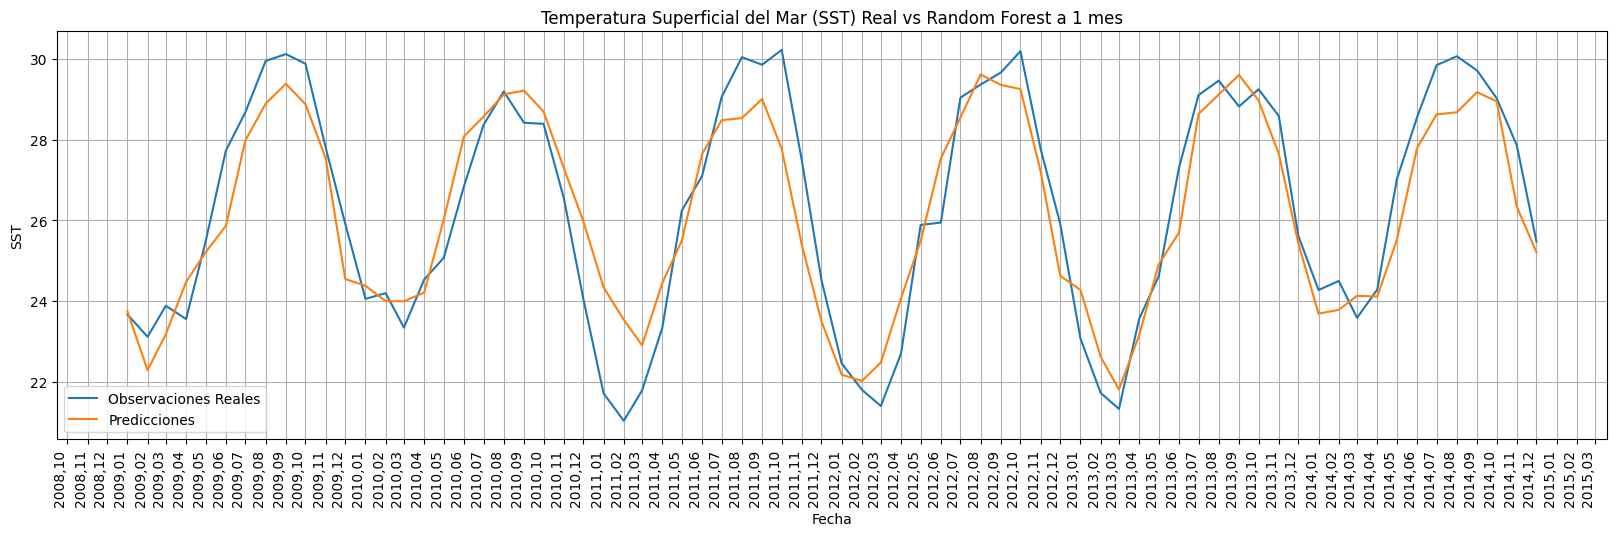

In [48]:
# Gráfico
plt.figure(figsize=(20, 6))
#plt.plot(df_adjust['Fecha'], df_adjust['SST'],linestyle='-', label='Observaciones Reales')
plt.plot(df_adjust['Fecha'], actual,linestyle='-', label='Observaciones Reales')
plt.plot(df_adjust['Fecha'], resultados['Prediccion_SST'],  linestyle='-', label='Predicciones')
plt.title('Temperatura Superficial del Mar (SST) Real vs Random Forest a 1 mes')
plt.xlabel('Fecha')
plt.ylabel('SST')
plt.legend()

# Formatear el eje x para mostrar cada año
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y,%m'))
plt.gcf().autofmt_xdate()  # Auto-rotar las fechas para que sean legibles
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [49]:
meanPred = np.mean(np.abs(resultados['Prediccion_SST']))

In [50]:
rmse = np.sqrt(mean_squared_error( actual, resultados['Prediccion_SST']))
print(f"RMSE: {rmse}")

RMSE: 1.0317389177522116


In [51]:
meanReal = np.mean(np.abs(df_adjust['SST']))

In [52]:
print("Error promedio de la temperatura predicha", meanPred)
print("Error promedio de la temperatura real", meanReal)
print(np.abs(meanReal-meanPred))

Error promedio de la temperatura predicha 26.148328783333334
Error promedio de la temperatura real 26.302553055555556
0.15422427222222268
